# Test of bespoke neural network

Import necessary modules:

In [1]:
from classes.MyModel import MyModel
import torch
import torch.nn as nn
import math as math
from pathlib import Path
import numpy as np
from torchviz import make_dot

from modules.helper_functions_tsp import (find_problem_size,
load_dict_from_json, read_file_name, validate_distance_array,
cost_fn_fact, cost_fn_tensor, hot_start, hot_start_list_to_string)

from modules.config import NETWORK_DIR, DATA_SOURCES, GRAPH_DIR
from modules.helper_ML_functions import find_device
from modules.graph_functions import (plot_sine_activation,
                                     plot_model_training)

Set up constants:

In [ ]:
LOCATIONS = 6                       #locations in problem
DECODING_FORMULATION = 'original'   #decoding formulation
                                    #options: 'original', 'new'
GRAY = False                        #gray code  
STD_DEV = 0.1                       #standard deviation for weight randomization
NUM_EPOCHS = 1000                   #number of epochs for training
NUM_LAYERS = 2                      #number of layers in the mode
LR = 0.0001                         #Learning rate
VERBOSE = False                     #controls how much output the model produces
BATCH_SIZE = 64                     #size of input tensor.  Reduces randomness
MOMENTUM = 0.0                      #momentum for optimizer
WEIGHT_DECAY = 0.0002               #importance of L2 regularization in optimiser
OPTIMIZER = 'Adam'                  #optimizer to use
                                    #options: 'Adam', 'SGD'
     

Read in data and report on data read:

In [3]:
sources_filename = Path(NETWORK_DIR).joinpath(DATA_SOURCES)
data_source_dict = load_dict_from_json(sources_filename)
filename = read_file_name(str(LOCATIONS), data_source_dict)
filepath = Path(NETWORK_DIR).joinpath(filename)
best_dist = data_source_dict[str(LOCATIONS)]['best']
print(f'Data will be read from filename {filepath}.  It is known that the shortest distance is {best_dist}.')

Reading distance data
Data will be read from filename networks\five_d.txt.  It is known that the shortest distance is 19.


Read in and validate distance array:

In [4]:
distance_array = np.genfromtxt(filepath)
validate_distance_array(distance_array, LOCATIONS)

Evaluate cost function and clear cache:

In [5]:
cost_fn = cost_fn_fact(LOCATIONS, distance_array, GRAY, method = DECODING_FORMULATION, verbose=VERBOSE)
cost_fn.clear_cache()

Check if CUDA is available and set the device

In [6]:
device = find_device()
print(f"Using device: {device}")

Using device: cuda


Find problem size:

In [7]:
qubits = find_problem_size(LOCATIONS, DECODING_FORMULATION)
print(f'There are {qubits} qubits needed for {LOCATIONS} locations in the {DECODING_FORMULATION} formulation.')

There are 5 qubits needed for 5 locations in the original formulation.


Find a hot start using a lazy classical algorithm and find the quality of the hot start:

In [8]:
hot_start_list = hot_start(distance_array, LOCATIONS)
print(f'The hot start location list is {hot_start_list}')
bin_hot_start_list =  hot_start_list_to_string(hot_start_list, LOCATIONS, GRAY, DECODING_FORMULATION)
print(f'This is equivalent to a binary list: {bin_hot_start_list}')
bin_hot_start_list_tensor = torch.tensor([bin_hot_start_list])
print(f'bin_hot_start_list_tensor = {bin_hot_start_list_tensor}')
distance_tensor = cost_fn_tensor(bin_hot_start_list_tensor, cost_fn).clone().detach().requires_grad_(True)
print(f'The hot start distance is {float(distance_tensor):.1f}, compared to a best distance of {best_dist:.1f}.')

The hot start location list is [0, 3, 2, 1, 4]
This is equivalent to a binary list: [1, 0, 0, 1, 0]
bin_hot_start_list_tensor = tensor([[1, 0, 0, 1, 0]])
The hot start distance is 21.0, compared to a best distance of 19.0.


Set up input as repeated hot start tensor calculated above:

In [9]:
unrepeated_input = bin_hot_start_list_tensor.float().to(device)
my_input = unrepeated_input.repeat(BATCH_SIZE, 1).requires_grad_(True)

Set up model with gradient required:

In [10]:

model = MyModel(qubits, NUM_LAYERS, STD_DEV, cost_fn).to(device)
for param in model.parameters():
    param.requires_grad = True

Report on model parameters:

In [11]:
total_params = sum(
	param.numel() for param in model.parameters()
)
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

print(f'There are {total_params} parameters in total, of which {trainable_params} are trainable')

for name, param in model.named_parameters():
    print(f"Parameter {name} requires_grad: {param.requires_grad}")

There are 60 parameters in total, of which 60 are trainable
Parameter fc1.weight requires_grad: True
Parameter fc1.bias requires_grad: True
Parameter fc2.weight requires_grad: True
Parameter fc2.bias requires_grad: True


Test the Sine activation function and print out a graph:

Plot the sine activation function:

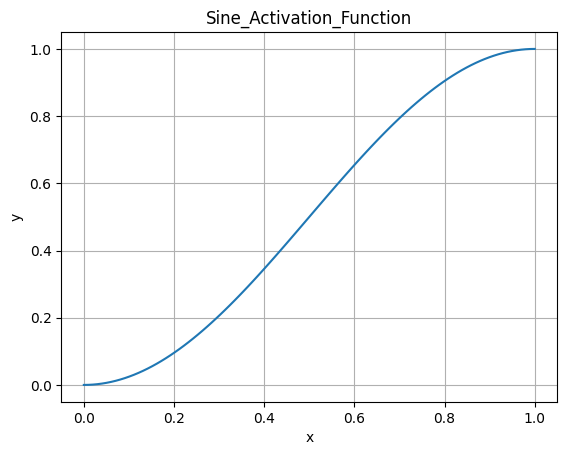

In [12]:
plot_sine_activation()

Print out model details including graph

Output = 22.625
{'fc1.weight': Parameter containing:
tensor([[ 1.0709, -0.0919, -0.0471,  0.1814,  0.0447],
        [-0.0878,  1.0173,  0.0425,  0.0282, -0.2663],
        [-0.0480,  0.1498,  0.9850,  0.0736, -0.1362],
        [-0.1406,  0.0997,  0.0974,  1.0160,  0.0625],
        [-0.1301, -0.1181, -0.0344,  0.0900,  0.9206]], device='cuda:0',
       requires_grad=True), 'fc1.bias': Parameter containing:
tensor([ 0.0881,  0.0309, -0.0681, -0.1035, -0.1469], device='cuda:0',
       requires_grad=True), 'fc2.weight': Parameter containing:
tensor([[ 1.0709, -0.0919, -0.0471,  0.1814,  0.0447],
        [-0.0878,  1.0173,  0.0425,  0.0282, -0.2663],
        [-0.0480,  0.1498,  0.9850,  0.0736, -0.1362],
        [-0.1406,  0.0997,  0.0974,  1.0160,  0.0625],
        [-0.1301, -0.1181, -0.0344,  0.0900,  0.9206]], device='cuda:0',
       requires_grad=True), 'fc2.bias': Parameter containing:
tensor([ 0.0881,  0.0309, -0.0681, -0.1035, -0.1469], device='cuda:0',
       requires_grad=True)}


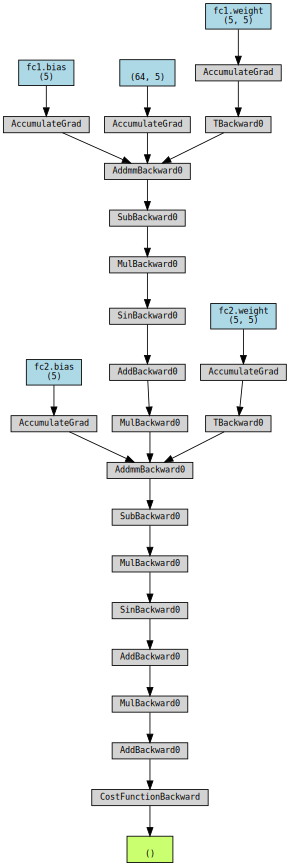

In [13]:
output = model(my_input)
lowest_cost = float(output)
print(f'Output = {output}')
filename = Path(GRAPH_DIR).joinpath('torchviz')

param_dict = dict(model.named_parameters())
print(param_dict)  # Debugging: print the parameters to ensure they seem reasonable
make_dot(output, params=param_dict).render(filename, format="png")
make_dot(output, params=param_dict)

In [14]:
target = torch.tensor(0.0, requires_grad=True)
criterion = nn.L1Loss()
if OPTIMIZER == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
elif OPTIMIZER == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), momentum=MOMENTUM, lr=LR, weight_decay=WEIGHT_DECAY)
else:
    raise ValueError(f'Optimizer {OPTIMIZER} not recognized')
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [16]:
epoch_history = []
loss_history = []
epoch_lowest_cost_found = 0
for epoch in range(NUM_EPOCHS):
    epoch_history.append(epoch)
    model_output = model(my_input)
    loss = criterion(model_output, target)
    loss_history.append(float(loss))
    loss.backward()
    optimizer.step()
    if float(model_output ) < lowest_cost:
        lowest_cost = float(loss)
        epoch_lowest_cost_found = epoch
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Cost: {loss:.3f}, Lowest Cost to date =  {lowest_cost:.3f}")
        # Check gradients
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f'Epoch {epoch}, {name} grad: {param.grad.norm():.2f}')
            else:
                print(f'Epoch {epoch}, {name} grad is None')

    optimizer.zero_grad()


Epoch 0, Cost: 21.469, Lowest Cost to date =  21.094
Epoch 0, fc1.weight grad: 411.48
Epoch 0, fc1.bias grad: 290.96
Epoch 0, fc2.weight grad: 395.58
Epoch 0, fc2.bias grad: 340.15
Epoch 50, Cost: 21.375, Lowest Cost to date =  21.094
Epoch 50, fc1.weight grad: 340.75
Epoch 50, fc1.bias grad: 240.95
Epoch 50, fc2.weight grad: 345.52
Epoch 50, fc2.bias grad: 295.67
Epoch 100, Cost: 21.281, Lowest Cost to date =  21.094
Epoch 100, fc1.weight grad: 281.61
Epoch 100, fc1.bias grad: 199.13
Epoch 100, fc2.weight grad: 299.57
Epoch 100, fc2.bias grad: 255.10
Epoch 150, Cost: 21.281, Lowest Cost to date =  21.000
Epoch 150, fc1.weight grad: 231.60
Epoch 150, fc1.bias grad: 163.76
Epoch 150, fc2.weight grad: 257.03
Epoch 150, fc2.bias grad: 217.78
Epoch 200, Cost: 21.281, Lowest Cost to date =  21.000
Epoch 200, fc1.weight grad: 185.25
Epoch 200, fc1.bias grad: 130.99
Epoch 200, fc2.weight grad: 213.10
Epoch 200, fc2.bias grad: 179.63
Epoch 250, Cost: 21.000, Lowest Cost to date =  21.000
Epoch

Plot loss ratio by epoch:

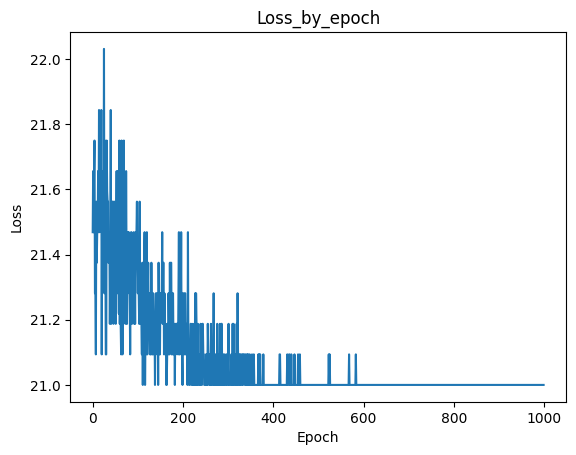

In [18]:
plot_model_training(epoch_history, loss_history)

In [19]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print('weight:', layer.weight)
        print('bias:', layer.bias)

weight: Parameter containing:
tensor([[ 1.0957e+00, -1.2807e-02, -2.2997e-04,  2.0626e-01,  1.3589e-04],
        [-1.5813e-01,  8.9980e-01,  8.0127e-05, -4.2159e-02, -1.5846e-01],
        [-1.0623e-01,  5.3349e-02,  8.6762e-01,  1.5312e-02, -4.2545e-02],
        [-1.0226e-01,  1.7137e-02,  1.5793e-02,  1.0543e+00,  1.9884e-03],
        [-2.0302e-01, -2.9107e-02, -5.0069e-06,  1.7081e-02,  8.0344e-01]],
       device='cuda:0', requires_grad=True)
bias: Parameter containing:
tensor([ 0.1130, -0.0395, -0.1263, -0.0652, -0.2199], device='cuda:0',
       requires_grad=True)
weight: Parameter containing:
tensor([[ 1.0830, -0.0275,  0.0063,  0.1959,  0.0764],
        [-0.0947,  0.9411, -0.0201,  0.0188, -0.2990],
        [-0.0566,  0.0826,  0.9282,  0.0621, -0.1728],
        [-0.0979,  0.1942,  0.1814,  1.0616,  0.1297],
        [-0.1504, -0.1520, -0.0655,  0.0689,  0.8963]], device='cuda:0',
       requires_grad=True)
bias: Parameter containing:
tensor([ 0.1016,  0.0225, -0.0783, -0.0591, -0